# auto feature nyc taxi +  training

## pipeline:

1. RecDP will automtaiclly defer (schema_infer) each columns' type, will do try_decode. 
2. Then RecDP will do data clean (data profiler) 
    * i.e., fillNA, currently we can handle default for datetime, string, numerica -int, float. 
    * i.e., missing value impute 
3. Then RecDp will do feature engineering automatically (feature wrangler) 
    * call different primtives based on data type
    * i.e., decode text tokens 
    * We will use AutoFE to generate new additional features 
    * date time -> week of year, month, .... 
    * text -> count unique value
4. Drop features - get data ready for train 
    * drop duplicated features 
    * transfomer features which not ready for training -> categorify 

# 0. Download data and split train/test

In [1]:
from pyrecdp.datasets import nyc_taxi
full_data = nyc_taxi().to_pandas()
num_rows = full_data.shape[0]
train_test_split_row = int(num_rows * 0.9)
print(f"train test split row is {train_test_split_row}")

train_data = full_data[full_data.index <= train_test_split_row]
train_data.to_csv("nyx_taxi_fare_predict_train.csv", index = False)
test_data = full_data[full_data.index > train_test_split_row]
test_data.to_csv("nyx_taxi_fare_predict_test.csv", index = False)

train test split row is 48884359


## 1. Load Datasets

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
train_data = pd.read_csv("nyx_taxi_fare_predict_train.csv")
display(train_data)

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...
48884355,3.7,2011-04-06 15:11:00 UTC,-74.005158,40.721093,-74.002250,40.729252,1
48884356,12.9,2011-12-13 20:43:00 UTC,-73.963960,40.808177,-73.999557,40.738487,1
48884357,9.0,2013-10-16 11:28:00 UTC,-73.974290,40.759570,-73.962308,40.778295,3
48884358,10.9,2009-08-21 22:58:00 UTC,-73.977622,40.752322,-73.984978,40.719053,4


## 2. Generate pipeline for training

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


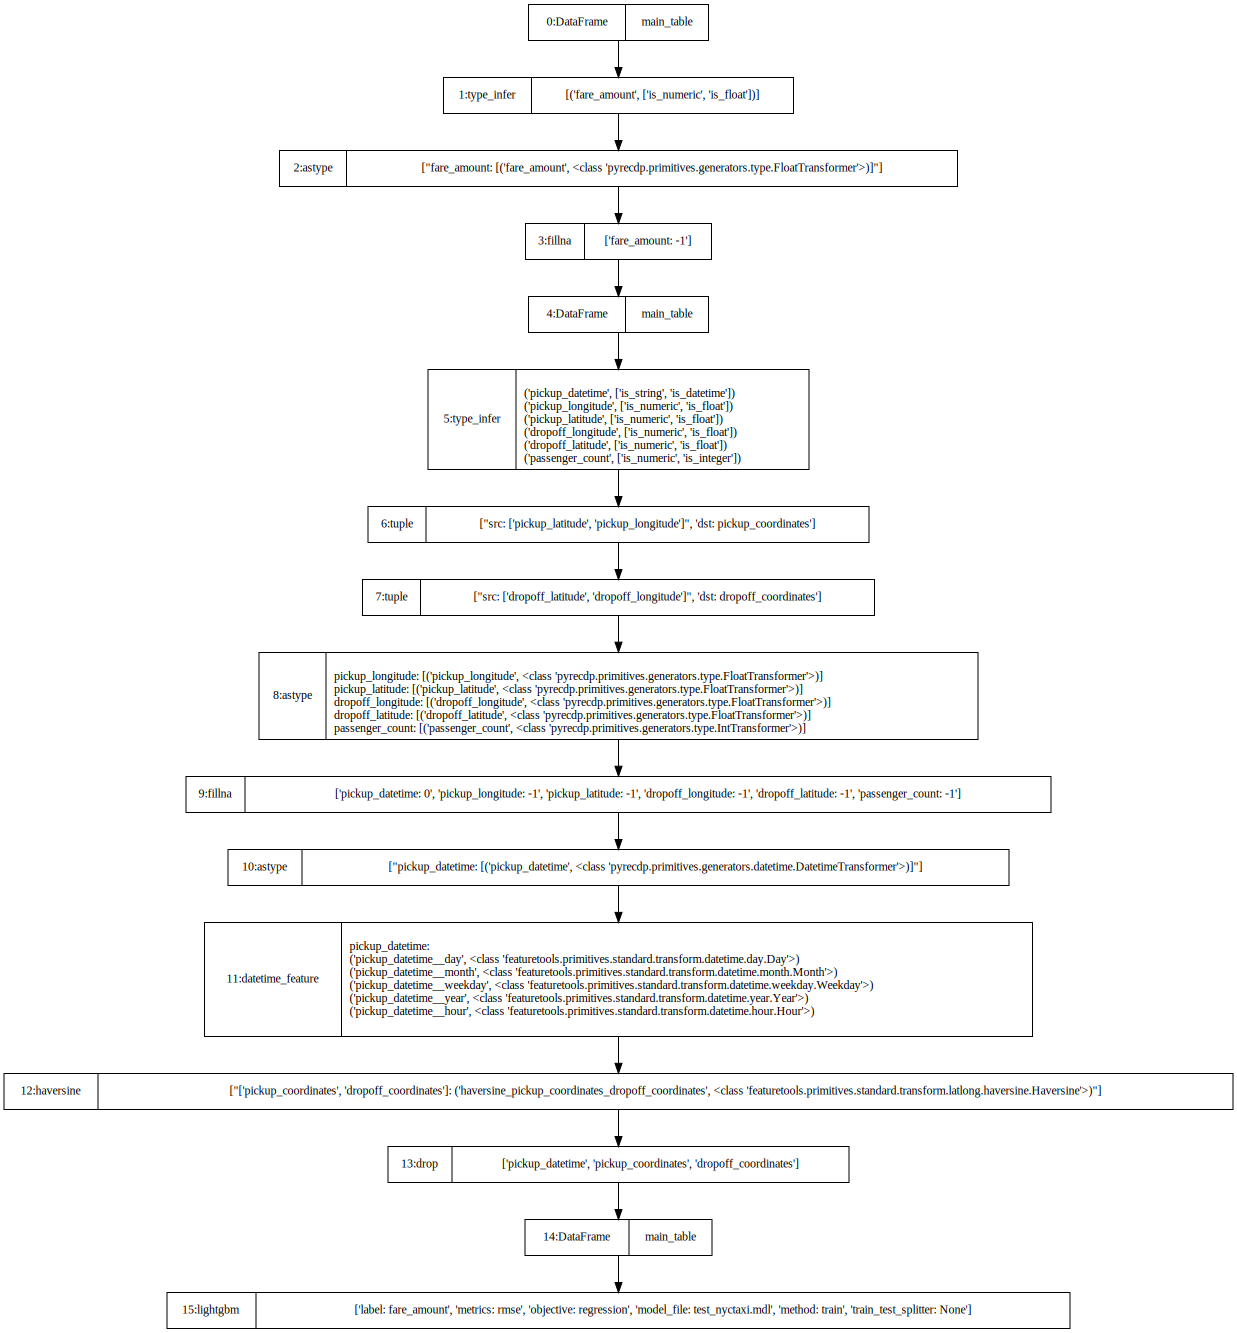

In [3]:
from pyrecdp.autofe import FeatureWrangler, DataEstimator

data_pipeline = FeatureWrangler(dataset=train_data, label="fare_amount")

config = {
    'model_file': 'test_nyctaxi.mdl',
    'metrics': 'rmse', 
    'objective': 'regression', 
    'model_name': 'lightgbm'}
train_pipeline = DataEstimator(method = 'train', data_pipeline = data_pipeline, config = config)
train_pipeline.plot()

## 3. execute pipeline with spark

In [4]:
transformed_data = train_pipeline.fit_transform('spark')
display(transformed_data)

Will assign 48 cores and 308502 M memory for spark
23/04/03 17:25:28 WARN Utils: Your hostname, sr414 resolves to a loopback address: 127.0.1.1; using 10.1.2.14 instead (on interface enp134s0f1)
23/04/03 17:25:28 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/03 17:25:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
per core memory size is 6.276 GB and shuffle_disk maximum capacity is 8589934592.000 GB
{0: DataFrame, 1: type_infer, 2: astype, 3: fillna, 4: DataFrame, 5: type_infer, 6: tuple, 7: tuple, 8: astype, 9: fillna, 10: astype, 11: datetime_feature, 12: haversine, 13: drop, 14: DataFrame, 15: lightgbm}
execute with spark started ...
append DataFrame
append type_infer
append DataFrameToRDDConverter
DataframeConvert partition pandas dataframe to spark RDD took 47.385 secs
append astype
append fillna
append DataFrame
append type_infer
append tuple
append tuple
append astype
append fillna
append astype
append datetime_feature
append haversine
append drop
append DataFrame
append lightgbm
append RDDToDataFrameConverter


DataframeTransform took 129.868 secs, processed 48884360 rows with num_partitions as 200
DataframeTransform combine to one pandas dataframe took 2.101 secs


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_w

[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 2.354287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25091
[LightGBM] [Info] Number of data points in the train set: 46440142, number of used features: 11


/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] bagging_fraction is set=1, subsample=0.8 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Info] Start training from score 11.324528
Training until validation scores don't improve for 50 rounds
[100]	valid_0's rmse: 3.94768
[200]	valid_0's rmse: 3.83113
[300]	valid_0's rmse: 3.76642
[400]	valid_0's rmse: 3.72327
[500]	valid_0's rmse: 3.69523
[600]	valid_0's rmse: 3.67386
[700]	valid_0's rmse: 3.65778
[800]	valid_0's rmse: 3.64214
[900]	valid_0's rmse: 3.62791
[1000]	valid_0's rmse: 3.61577
[1100]	valid_0's rmse: 3.60468
[1200]	valid_0's rmse: 3.59379
[1300]	valid_0's rmse: 3.58517
[1400]	valid_0's rmse: 3.57635
[1500]	valid_0's rmse: 3.56981
[1600]	valid_0's rmse: 3.56516
[1700]	valid_0's rmse: 3.56009
[1800]	valid_0's rmse: 3.55654
[1900]	valid_0's rmse: 3.55266
[2000]	valid_0's rmse: 3.54776
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 3.54776
append RDDToDataFrameConverter


DataframeTransform took 73.673 secs, processed 48884360 rows with num_partitions as 200
DataframeTransform combine to one pandas dataframe took 2.087 secs
execute with spark took 1421.6192996888421 sec


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime__day,pickup_datetime__month,pickup_datetime__weekday,pickup_datetime__year,pickup_datetime__hour,haversine_pickup_coordinates_dropoff_coordinates
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,15,6,0,2009,17,0.640488
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,5,1,1,2010,16,5.250677
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,18,8,3,2011,0,0.863412
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,21,4,5,2012,4,1.739388
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,9,3,1,2010,7,1.242220
...,...,...,...,...,...,...,...,...,...,...,...,...
48884355,3.7,-74.005158,40.721093,-74.002250,40.729252,1,6,4,2,2011,15,0.583936
48884356,12.9,-73.963960,40.808177,-73.999557,40.738487,1,13,12,1,2011,20,5.162812
48884357,9.0,-73.974290,40.759570,-73.962308,40.778295,3,16,10,2,2013,11,1.437696
48884358,10.9,-73.977622,40.752322,-73.984978,40.719053,4,21,8,4,2009,22,2.330707


# 4. export pipeline to JSON

In [5]:
train_pipeline.export('nyc_taxi_pipeline.json')

In [7]:
! cat nyc_taxi_pipeline.json

{
    "0": {
        "children": null,
        "op": "DataFrame",
        "config": "main_table"
    },
    "1": {
        "children": [
            0
        ],
        "op": "type_infer",
        "config": [
            [
                "fare_amount",
                [
                    "is_numeric",
                    "is_float"
                ]
            ]
        ]
    },
    "2": {
        "children": [
            1
        ],
        "op": "astype",
        "config": {
            "fare_amount": [
                [
                    "fare_amount",
                    [
                        "pyrecdp.primitives.generators.type",
                        "FloatTransformer"
                    ]
                ]
            ]
        }
    },
    "3": {
        "children": [
            2
        ],
        "op": "fillna",
        "config": {
            "fare_amount": -1
        }
    },
    "4": {
        "children": [
            3
        ],
        "op": "DataFrame

## Optional - process with pandas

In [3]:
pipeline.fit_transform('pandas')

Will assign 48 cores and 308513 M memory for spark
23/03/06 09:25:18 WARN Utils: Your hostname, sr419 resolves to a loopback address: 127.0.1.1; using 10.0.2.19 instead (on interface ens818f1)
23/03/06 09:25:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/06 09:25:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
per core memory size is 6.277 GB and shuffle_disk maximum capacity is 8589934592.000 GB
append DataFrame
append type_infer
append DataFrameToRDDConverter
DataframeConvert partition pandas dataframe to spark RDD took 0.320 secs
append tuple
append tuple
append fillna
append datetime_feature
append haversine
append drop
append RDDToDataFrameConverter
execute with spark started ...


DataframeTransform took 5.644 secs, processed 10000 rows with num_partitions as 200
DataframeTransform combine to one pandas dataframe took 0.015 secs
execute with spark took 5.6608173889108 sec


,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime__day,pickup_datetime__month,pickup_datetime__weekday,pickup_datetime__year,pickup_datetime__hour,haversine_pickup_coordinates_dropoff_coordinates
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,15,6,0,2009,17,0.640488
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,5,1,1,2010,16,5.250677
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,18,8,3,2011,0,0.863412
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,21,4,5,2012,4,1.739388
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,9,3,1,2010,7,1.242220
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,16.9,-73.994594,40.732393,-73.974557,40.788259,1,30,1,5,2010,22,3.999877
9996,5.5,-74.001017,40.746352,-73.990873,40.739497,1,23,1,3,2014,18,0.711558
9997,4.5,-74.005530,40.720826,-73.996565,40.716309,1,5,5,3,2011,19,0.563746
9998,8.0,-74.001850,40.745591,-74.006125,40.723338,1,4,8,6,2013,11,1.553741
